In [1]:
import sys
sys.path.append("../../src/earthtext")

import geopandas as gpd
import shapely as sh
from pyproj import CRS
epsg4326 = CRS.from_epsg(4326)
import pandas as pd
from progressbar import progressbar as pbar
import numpy as np
import matplotlib.pyplot as plt
import geoplot
import geoplot.crs as gcrs
from importlib import reload
from osm import osm
import os
import shutil
repodata = "../../data"
localdata = "/opt/data/osm"
reload(osm)

<module 'osm.osm' from '/home/ubuntu/earth-text/notebooks/osm/../../src/earthtext/osm/osm.py'>

## boundaries

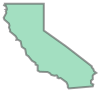

In [2]:
cc = gpd.read_file(f"/opt/data/osm/CA_State_TIGER2016.shp").to_crs(epsg4326)
c = cc.geometry[0]
c = list(c.geoms)[6].simplify(tolerance=.05)
caldf = gpd.GeoDataFrame(geometry=[c], crs=epsg4326)
c

## california comes in two separate regions in OSM dumps

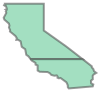

In [3]:
norcal_bbox = [-126.434293,35.78528,-115.603799,42.434005]
socal_bbox  = [-121.440088,32.344928,-113.860038,35.81055]
norcal = sh.geometry.box(*norcal_bbox, ccw=True).intersection(c)
socal  = sh.geometry.box(*socal_bbox, ccw=True).intersection(c)
sh.geometry.GeometryCollection([norcal, socal])

## split in random chips

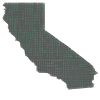

In [4]:
norcalk = osm.katana(norcal, threshold=.3)
socalk  = osm.katana(socal, threshold=.3)
sh.geometry.GeometryCollection(norcalk + socalk)

## create geo dataframe

In [5]:
norcal_cg = gpd.GeoDataFrame(geometry=norcalk, crs = epsg4326)
norcal_cg['identifier'] = [osm.get_region_hash(gi) for gi in norcal_cg.geometry]

socal_cg = gpd.GeoDataFrame(geometry=socalk, crs = epsg4326)
socal_cg['identifier'] = [osm.get_region_hash(gi) for gi in socal_cg.geometry]

socal_cg.head()

,geometry,identifier
0,"POLYGON ((-120.68454 34.52714, -120.68534 34.6...",0d0572d2009be
1,"POLYGON ((-120.68668 34.76760, -120.53255 34.7...",194486a04809d
2,"POLYGON ((-120.53255 34.76760, -120.68668 34.7...",1b8e6f931c543
3,"POLYGON ((-120.53255 35.14678, -120.53255 34.9...",10319cb117087
4,"POLYGON ((-121.44009 35.77029, -121.44009 35.8...",0a86a1088d621


In [6]:
socal_cg.shape, norcal_cg.shape

((345, 2), (639, 2))

In [ ]:
with open(f"{repodata}/california.wkt", "w") as f:
    f.write(sh.to_wkt(c))

In [8]:
norcal_cg['partition'] = 'north'
socal_cg['partition'] = 'south'

# remove intersecting parts to have a clear cover
socal_cg['geometry'] = [ gi - gi.intersection(norcal) if gi.intersects(norcal) else gi for gi in socal_cg.geometry]

In [9]:
cg = pd.concat([norcal_cg, socal_cg])
cg.head()

,geometry,identifier,partition
0,"POLYGON ((-121.97110 36.35577, -121.99837 36.4...",10cadd98c5e97,north
1,"POLYGON ((-121.97110 36.65842, -121.97110 36.4...",30564f0349b5a,north
2,"POLYGON ((-122.07605 36.90828, -121.97110 36.9...",0d701755edfc6,north
3,"POLYGON ((-122.46413 37.17785, -122.47272 37.2...",2443e273f3f87,north
4,"POLYGON ((-122.07641 36.91020, -122.21492 37.0...",06b361293f254,north


In [ ]:
cg.to_file(f"{localdata}/california-parts.geojson", driver="GeoJSON")

In [10]:
cg.partition.value_counts()

partition
north    639
south    345
Name: count, dtype: int64

In [ ]:
cg.explore()

## create one geojson per chip

In [12]:
shutil.rmtree(f"{localdata}/california-parts", ignore_errors=True)
os.makedirs(f"{localdata}/california-parts", exist_ok=True)

for _,g in cg.iterrows():
    geojson = sh.to_geojson(g.geometry)
    with open(f"{localdata}/california-parts/{g.identifier}.geojson", "w") as f:
        f.write('{"type": "Feature", "geometry": ' + sh.to_geojson(g.geometry, indent=2) + ' }')

## create one pbf per chip using `osmium` cmd

In [13]:
from rlxutils import Command

In [ ]:
for i,(_,g) in pbar(enumerate(cg.iterrows()), maxval=len(cg)):
    geojson = sh.to_geojson(g.geometry)
    geojson_file = f"{localdata}/california-parts/{g.identifier}.geojson"
    pbf_file     = f"{localdata}/california-parts/{g.identifier}.pbf"

    if g.partition == 'south':
        input_pbf = f"{localdata}/socal-latest.osm.pbf"
    else:
        input_pbf = f"{localdata}/norcal-latest.osm.pbf"
        
    with open(geojson_file, "w") as f:
        f.write('{"type": "Feature", "geometry": ' + sh.to_geojson(g.geometry, indent=2) + ' }')

    cmd = f"osmium extract {input_pbf} --polygon {geojson_file} --overwrite -o {pbf_file}"
    cmd = Command(cmd)

    cmd.run().wait()


 86% (853 of 984) |###################   | Elapsed Time: 2:05:25 ETA:   0:19:15